# FCN图像语义分割

全卷积网络（Fully Convolutional Networks，FCN）是UC Berkeley的Jonathan Long等人于2015年在Fully Convolutional Networks for Semantic Segmentation<sup>[1]</sup>一文中提出的用于图像语义分割的一种框架。

FCN是首个端到端（end to end）进行像素级（pixel level）预测的全卷积网络。

![fcn-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_1.png)

## 语义分割

在具体介绍FCN之前，首先介绍何为语义分割：

图像语义分割（semantic segmentation）是图像处理和机器视觉技术中关于图像理解的重要一环，AI领域中一个重要分支，常被应用于人脸识别、物体检测、医学影像、卫星图像分析、自动驾驶感知等领域。

语义分割的目的是对图像中每个像素点进行分类。与普通的分类任务只输出某个类别不同，语义分割任务输出与输入大小相同的图像，输出图像的每个像素对应了输入图像每个像素的类别。语义在图像领域指的是图像的内容，对图片意思的理解，下图是一些语义分割的实例：

![fcn-2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_2.png)

## 模型简介

FCN主要用于图像分割领域，是一种端到端的分割方法，是深度学习应用在图像语义分割的开山之作。通过进行像素级的预测直接得出与原图大小相等的label map。因FCN丢弃全连接层替换为全卷积层，网络所有层均为卷积层，故称为全卷积网络。

全卷积神经网络主要使用以下三种技术：

1. 卷积化（Convolutional）

    使用VGG-16作为FCN的backbone。VGG-16的输入为224*224的RGB图像，输出为1000个预测值。VGG-16只能接受固定大小的输入，丢弃了空间坐标，产生非空间输出。VGG-16中共有三个全连接层，全连接层也可视为带有覆盖整个区域的卷积。将全连接层转换为卷积层能使网络输出由一维非空间输出变为二维矩阵，利用输出能生成输入图片映射的heatmap。

   ![fcn-3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_3.png)

2. 上采样（Upsample）

    在卷积过程的卷积操作和池化操作会使得特征图的尺寸变小，为得到原图的大小的稠密图像预测，需要对得到的特征图进行上采样操作。使用双线性插值的参数来初始化上采样逆卷积的参数，后通过反向传播来学习非线性上采样。在网络中执行上采样，以通过像素损失的反向传播进行端到端的学习。

    ![fcn-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_4.png)

3. 跳跃结构（Skip Layer）

    利用上采样技巧对最后一层的特征图进行上采样得到原图大小的分割是步长为32像素的预测，称之为FCN-32s。由于最后一层的特征图太小，损失过多细节，采用skips结构将更具有全局信息的最后一层预测和更浅层的预测结合，使预测结果获取更多的局部细节。将底层（stride 32）的预测（FCN-32s）进行2倍的上采样得到原尺寸的图像，并与从pool4层（stride 16）进行的预测融合起来（相加），这一部分的网络被称为FCN-16s。随后将这一部分的预测再进行一次2倍的上采样并与从pool3层得到的预测融合起来，这一部分的网络被称为FCN-8s。 Skips结构将深层的全局信息与浅层的局部信息相结合。

    ![fcn-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_5.png)

## 网络特点

1. 不含全连接层(fc)的全卷积(fully conv)网络，可适应任意尺寸输入。  
2. 增大数据尺寸的反卷积(deconv)层，能够输出精细的结果。  
3. 结合不同深度层结果的跳级(skip)结构，同时确保鲁棒性和精确性。


## 数据处理

开始实验前，需确保本地已经安装Python环境及MindSpore。

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.4.10，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.4.10
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/x86_64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.4.10
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: mindnlp


In [3]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset_fcn8s.tar"

download(url, "./dataset", kind="tar", replace=True)

Creating data folder...

file_sizes: 100%|█████████████████████████████| 563M/563M [00:02<00:00, 206MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

### 数据预处理

由于PASCAL VOC 2012数据集中图像的分辨率大多不一致，无法放在一个tensor中，故输入前需做标准化处理。

### 数据加载

将PASCAL VOC 2012数据集与SDB数据集进行混合。

In [4]:
import numpy as np
import cv2
import mindspore.dataset as ds

class SegDataset:
    def __init__(self,
                 image_mean,
                 image_std,
                 data_file='',
                 batch_size=32,
                 crop_size=512,
                 max_scale=2.0,
                 min_scale=0.5,
                 ignore_label=255,
                 num_classes=21,
                 num_readers=2,
                 num_parallel_calls=4):

        self.data_file = data_file
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.image_mean = np.array(image_mean, dtype=np.float32)
        self.image_std = np.array(image_std, dtype=np.float32)
        self.max_scale = max_scale
        self.min_scale = min_scale
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.num_readers = num_readers
        self.num_parallel_calls = num_parallel_calls
        max_scale > min_scale

    def preprocess_dataset(self, image, label):
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        image_out = (image_out - self.image_mean) / self.image_std
        out_h, out_w = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = out_h - new_h, out_w - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, out_h - self.crop_size + 1)
        offset_w = np.random.randint(0, out_w - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        label_out = label_out.astype("int32")
        return image_out, label_out

    def get_dataset(self):
        ds.config.set_numa_enable(True)
        dataset = ds.MindDataset(self.data_file, columns_list=["data", "label"],
                                 shuffle=True, num_parallel_workers=self.num_readers, num_samples=20)
        transforms_list = self.preprocess_dataset
        dataset = dataset.map(operations=transforms_list, input_columns=["data", "label"],
                              output_columns=["data", "label"],
                              num_parallel_workers=self.num_parallel_calls)
        dataset = dataset.shuffle(buffer_size=self.batch_size * 10)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset


# 定义创建数据集的参数
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset/dataset_fcn8s/mindname.mindrecord"

# 定义模型训练参数
train_batch_size = 4
crop_size = 512
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21

# 实例化Dataset
dataset = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=train_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)

dataset = dataset.get_dataset()

### 训练集可视化

运行以下代码观察载入的数据集图片（数据处理过程中已做归一化处理）。

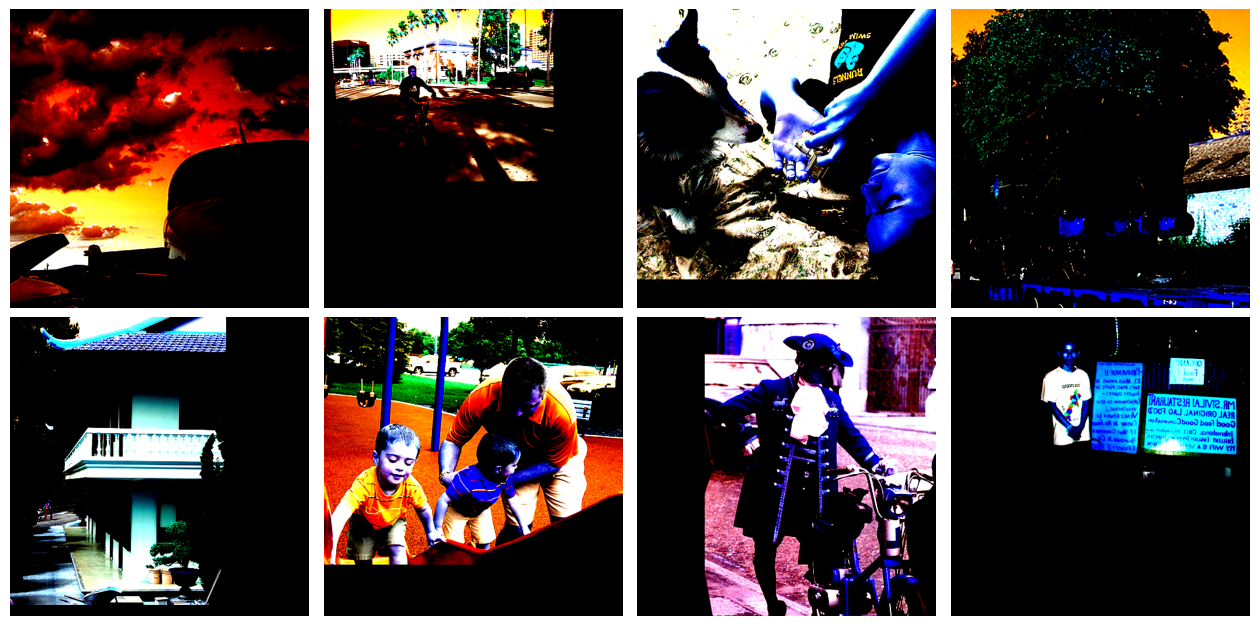

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# 对训练集中的数据进行展示
for i in range(1, 9):
    plt.subplot(2, 4, i)
    show_data = next(dataset.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images, 0, 1)
# 将图片转换HWC格式后进行展示
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

## 网络构建

### 网络流程

FCN网络的流程如下图所示：

1. 输入图像image，经过pool1池化后，尺寸变为原始尺寸的1/2。
2. 经过pool2池化，尺寸变为原始尺寸的1/4。
3. 接着经过pool3、pool4、pool5池化，大小分别变为原始尺寸的1/8、1/16、1/32。
4. 经过conv6-7卷积，输出的尺寸依然是原图的1/32。
5. FCN-32s是最后使用反卷积，使得输出图像大小与输入图像相同。
6. FCN-16s是将conv7的输出进行反卷积，使其尺寸扩大两倍至原图的1/16，并将其与pool4输出的特征图进行融合，后通过反卷积扩大到原始尺寸。
7. FCN-8s是将conv7的输出进行反卷积扩大4倍，将pool4输出的特征图反卷积扩大2倍，并将pool3输出特征图拿出，三者融合后通反卷积扩大到原始尺寸。

![fcn-6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3/tutorials/application/source_zh_cn/cv/images/fcn_6.png)

使用以下代码构建FCN-8s网络。

In [6]:
import mindspore.nn as nn

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        self.conv1 = nn.SequentialCell(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.SequentialCell(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.SequentialCell(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.SequentialCell(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                  kernel_size=1, weight_init='xavier_uniform')
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')

    def construct(self, x):
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)
        x6 = self.conv6(p5)
        x7 = self.conv7(x6)
        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)
        s4 = self.score_pool4(p4)
        f4 = s4 + u2
        u4 = self.upscore_pool4(f4)
        s3 = self.score_pool3(p3)
        f3 = s3 + u4
        out = self.upscore8(f3)
        return out

## 训练准备

### 导入VGG-16部分预训练权重

FCN使用VGG-16作为骨干网络，用于实现图像编码。使用下面代码导入VGG-16预训练模型的部分预训练权重。

In [7]:
from download import download
from mindspore import load_checkpoint, load_param_into_net

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/fcn8s_vgg16_pretrain.ckpt"
download(url, "fcn8s_vgg16_pretrain.ckpt", replace=True)
def load_vgg16():
    ckpt_vgg16 = "fcn8s_vgg16_pretrain.ckpt"
    param_vgg = load_checkpoint(ckpt_vgg16)
    load_param_into_net(net, param_vgg)


file_sizes: 100%|█████████████████████████████| 538M/538M [00:02<00:00, 194MB/s]
Successfully downloaded file to fcn8s_vgg16_pretrain.ckpt


### 损失函数

语义分割是对图像中每个像素点进行分类，仍是分类问题，故损失函数选择交叉熵损失函数来计算FCN网络输出与mask之间的交叉熵损失。这里我们使用的是mindspore.nn.CrossEntropyLoss()作为损失函数。

### 自定义评价指标 Metrics

这一部分主要对训练出来的模型效果进行评估，为了便于解释，假设如下：共有 $k+1$ 个类（从 $L_0$ 到 $L_k$, 其中包含一个空类或背景）， $p_{i j}$ 表示本属于$i$类但被预测为$j$类的像素数量。即, $p_{i i}$ 表示真正的数量, 而 $p_{i j} p_{j i}$ 则分别被解释为假正和假负, 尽管两者都是假正与假负之和。

- Pixel Accuracy(PA, 像素精度)：这是最简单的度量，为标记正确的像素占总像素的比例。

$$ P A=\frac{\sum_{i=0}^k p_{i i}}{\sum_{i=0}^k \sum_{j=0}^k p_{i j}} $$

- Mean Pixel Accuracy(MPA, 均像素精度)：是PA的一种简单提升，计算每个类内被正确分类像素数的比例，之后求所有类的平均。

$$ M P A=\frac{1}{k+1} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}} $$

- Mean Intersection over Union(MloU, 均交并比)：为语义分割的标准度量。其计算两个集合的交集和并集之，在语义分割的问题中，这两个集合为真实值（ground truth) 和预测值（predicted segmentation）。这个比例可以变形为正真数 (intersection) 比上真正、假负、假正（并集）之和。在每个类上计算loU，之后平均。

$$ M I o U=\frac{1}{k+1} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}+\sum_{j=0}^k p_{j i}-p_{i i}} $$

- Frequency Weighted Intersection over Union(FWIoU, 频权交井比)：为MloU的一种提升，这种方法根据每个类出现的频率为其设置权重。

$$ F W I o U=\frac{1}{\sum_{i=0}^k \sum_{j=0}^k p_{i j}} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}+\sum_{j=0}^k p_{j i}-p_{i i}} $$

In [8]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.train as train

class PixelAccuracy(train.Metric):
    def __init__(self, num_class=21):
        super(PixelAccuracy, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=1)
        y = inputs[1].asnumpy().reshape(4, 512, 512)
        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def eval(self):
        pixel_accuracy = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return pixel_accuracy


class PixelAccuracyClass(train.Metric):
    def __init__(self, num_class=21):
        super(PixelAccuracyClass, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=1)
        y = inputs[1].asnumpy().reshape(4, 512, 512)
        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        mean_pixel_accuracy = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        mean_pixel_accuracy = np.nanmean(mean_pixel_accuracy)
        return mean_pixel_accuracy


class MeanIntersectionOverUnion(train.Metric):
    def __init__(self, num_class=21):
        super(MeanIntersectionOverUnion, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=1)
        y = inputs[1].asnumpy().reshape(4, 512, 512)
        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        mean_iou = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))
        mean_iou = np.nanmean(mean_iou)
        return mean_iou


class FrequencyWeightedIntersectionOverUnion(train.Metric):
    def __init__(self, num_class=21):
        super(FrequencyWeightedIntersectionOverUnion, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=1)
        y = inputs[1].asnumpy().reshape(4, 512, 512)
        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))

        frequency_weighted_iou = (freq[freq > 0] * iu[freq > 0]).sum()
        return frequency_weighted_iou

## 模型训练

导入VGG-16预训练参数后，实例化损失函数、优化器，使用Model接口编译网络，训练FCN-8s网络。

PS: 虽然 在线CPU环境 对部分超参已进行了调整，但是训练仍存在内存不足 or 空间不足的情况，建议在Ascend/GPU 环境下执行以下代码。

In [9]:
import mindspore
from mindspore import Tensor
import mindspore.nn as nn
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Model

device_target = "CPU"
mindspore.set_context(mode=mindspore.PYNATIVE_MODE, device_target=device_target)

train_batch_size = 4
num_classes = 21
# 初始化模型结构
net = FCN8s(n_class=21)
# 导入vgg16预训练参数
load_vgg16()
# 计算学习率
min_lr = 0.0005
base_lr = 0.05
train_epochs = 1
iters_per_epoch = dataset.get_dataset_size()
total_step = iters_per_epoch * train_epochs

lr_scheduler = mindspore.nn.cosine_decay_lr(min_lr,
                                            base_lr,
                                            total_step,
                                            iters_per_epoch,
                                            decay_epoch=2)
lr = Tensor(lr_scheduler[-1])

# 定义损失函数
loss = nn.CrossEntropyLoss(ignore_index=255)
# 定义优化器
optimizer = nn.Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9, weight_decay=0.0001)
# 定义loss_scale
scale_factor = 4
scale_window = 3000
loss_scale_manager = ms.amp.DynamicLossScaleManager(scale_factor, scale_window)
# 初始化模型
if device_target == "Ascend":
    model = Model(net, loss_fn=loss, optimizer=optimizer, loss_scale_manager=loss_scale_manager, metrics={"pixel accuracy": PixelAccuracy(), "mean pixel accuracy": PixelAccuracyClass(), "mean IoU": MeanIntersectionOverUnion(), "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})
else:
    model = Model(net, loss_fn=loss, optimizer=optimizer, metrics={"pixel accuracy": PixelAccuracy(), "mean pixel accuracy": PixelAccuracyClass(), "mean IoU": MeanIntersectionOverUnion(), "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})

# 设置ckpt文件保存的参数
time_callback = TimeMonitor(data_size=iters_per_epoch)
loss_callback = LossMonitor()
callbacks = [time_callback, loss_callback]
save_steps = 330
keep_checkpoint_max = 5
config_ckpt = CheckpointConfig(save_checkpoint_steps=10,
                               keep_checkpoint_max=keep_checkpoint_max)
ckpt_callback = ModelCheckpoint(prefix="FCN8s",
                                directory="./ckpt",
                                config=config_ckpt)
callbacks.append(ckpt_callback)
# 以上是模型训练示例代码参考，建议在 CPU 环境直接进行下一步模型评估和推理，在线 CPU 环境可能无法支撑训练 (评估的是已经训练好的权重文件)
# model.train(train_epochs, dataset, callbacks=callbacks)

> 因为FCN网络在训练的过程中需要大量的训练数据和训练轮数，这里只提供了小数据单个epoch的训练来演示loss收敛的过程，下文中使用已训练好的权重文件进行模型评估和推理效果的展示。

## 模型评估

In [10]:
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset/dataset_fcn8s/mindname.mindrecord"

# 下载已训练好的权重文件
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/FCN8s.ckpt"
download(url, "FCN8s.ckpt", replace=True)
net = FCN8s(n_class=num_classes)

ckpt_file = "FCN8s.ckpt"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)

if device_target == "Ascend":
    model = Model(net, loss_fn=loss, optimizer=optimizer, loss_scale_manager=loss_scale_manager, metrics={"pixel accuracy": PixelAccuracy(), "mean pixel accuracy": PixelAccuracyClass(), "mean IoU": MeanIntersectionOverUnion(), "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})
else:
    model = Model(net, loss_fn=loss, optimizer=optimizer, metrics={"pixel accuracy": PixelAccuracy(), "mean pixel accuracy": PixelAccuracyClass(), "mean IoU": MeanIntersectionOverUnion(), "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})

# 实例化Dataset
dataset = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=train_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)
dataset_eval = dataset.get_dataset()
model.eval(dataset_eval)


file_sizes: 100%|███████████████████████████| 1.08G/1.08G [00:05<00:00, 183MB/s]
Successfully downloaded file to FCN8s.ckpt


/tmp/ipykernel_3647/29427089.py:52: RuntimeWarning: invalid value encountered in divide
  mean_pixel_accuracy = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
/tmp/ipykernel_3647/29427089.py:78: RuntimeWarning: invalid value encountered in divide
  mean_iou = np.diag(self.confusion_matrix) / (
/tmp/ipykernel_3647/29427089.py:107: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(self.confusion_matrix) / (


{'pixel accuracy': 0.9658202570484303,
 'mean pixel accuracy': 0.8844947043284125,
 'mean IoU': 0.7878009262642328,
 'frequency weighted IoU': 0.941952738727156}

## 模型推理

使用训练的网络对模型推理结果进行展示。

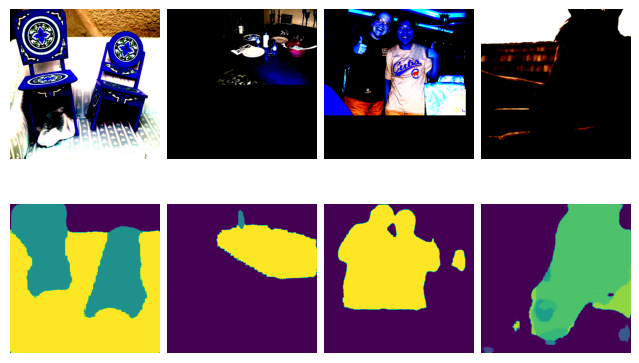

In [11]:
import cv2
import matplotlib.pyplot as plt

net = FCN8s(n_class=num_classes)
# 设置超参
ckpt_file = "FCN8s.ckpt"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)
eval_batch_size = 4
img_lst = []
mask_lst = []
res_lst = []
# 推理效果展示(上方为输入图片，下方为推理效果图片)
plt.figure(figsize=(8, 5))
show_data = next(dataset_eval.create_dict_iterator())
show_images = show_data["data"].asnumpy()
mask_images = show_data["label"].reshape([4, 512, 512])
show_images = np.clip(show_images, 0, 1)
for i in range(eval_batch_size):
    img_lst.append(show_images[i])
    mask_lst.append(mask_images[i])
res = net(show_data["data"]).asnumpy().argmax(axis=1)
for i in range(eval_batch_size):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img_lst[i].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.subplot(2, 4, i + 5)
    plt.imshow(res[i])
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.show()


## 总结

FCN的核心贡献在于提出使用全卷积层，通过学习让图片实现端到端分割。与传统使用CNN进行图像分割的方法相比，FCN有两大明显的优点：一是可以接受任意大小的输入图像，无需要求所有的训练图像和测试图像具有固定的尺寸。二是更加高效，避免了由于使用像素块而带来的重复存储和计算卷积的问题。

同时FCN网络也存在待改进之处：

一是得到的结果仍不够精细。进行8倍上采样虽然比32倍的效果好了很多，但是上采样的结果仍比较模糊和平滑，尤其是边界处，网络对图像中的细节不敏感。
二是对各个像素进行分类，没有充分考虑像素与像素之间的关系（如不连续性和相似性）。忽略了在通常的基于像素分类的分割方法中使用的空间规整（spatial regularization）步骤，缺乏空间一致性。

## 引用

[1]Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for Semantic Segmentation." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.